### Importando Bibliotecas a serem utilizadas

In [322]:
import yfinance as yf
import pandas as pd
from bcb import sgs, currency
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
np.float_ = np.float64
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Criando as tabelas

Utilizando a biblioteca Python 'yfinance' que possui os dados diários através do link(https://finance.yahoo.com/quote/%5EBVSP/history/)

O Yahoo Finance utiliza 5 colunas relativas a preço do ativos:

- Open -> Preço de abertura do dia do ativo (sem ajuste).
- High -> Maior preço alcançado no dia pelo ativo (sem ajuste).
- Low -> Menor preço alcançado no dia pelo ativo (sem ajuste).
- Close -> Preço de fechamento do dia do ativo (sem ajuste).
- Adj Close -> Preço de fechamento do dia do ativo (com ajuste) ##  Com o preço de fechamento, você verá apenas a mudança bruta no preço, enquanto o preço de fechamento ajustado também levará em consideração o dividendo. Para ações que não pagam dividendos, não haverá diferença entre esses dois valores.
- Volume -> Número de negócios que teve no dia.

In [4]:
#Importando os dados
start_date = '2021-05-06'
end_date = '2024-07-12'

df_origem = yf.download('^BVSP', start=start_date, end=end_date)
df_origem.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200


In [5]:
# Indice S&P/B3 Ibovespa VIX -> Avaliação de risco
df_vix = pd.read_excel('PerformanceGraphExport.xlsx')

In [6]:
df_vix = df_vix.set_index('Data efetiva')
df_vix.head()

,S&P/B3 Ibovespa VIX
Data efetiva,
2021-05-06,25.70
2021-05-07,24.01
2021-05-10,23.85
2021-05-11,24.97
2021-05-12,26.94


In [7]:
# Importando dados SELIC
selic_df = sgs.get(('selic', 432), start= '2021-05-06', end='2024-07-12')

selic_df.head()

,selic
Date,
2021-05-06,3.5
2021-05-07,3.5
2021-05-08,3.5
2021-05-09,3.5
2021-05-10,3.5


In [8]:
# Importando dados da taxa DOLAR
usd_brl = yf.download('BRL=X', start= '2021-05-06', end='2024-07-12')
usd_brl = usd_brl[['Close']].rename(columns={'Close':'Dollar'})
usd_brl.head()                                            

[*********************100%%**********************]  1 of 1 completed


,Dollar
Date,
2021-05-06,5.352700
2021-05-07,5.273431
2021-05-10,5.235500
2021-05-11,5.222200
2021-05-12,5.221200


In [9]:
def tabela_unica(df, df_juncao):
    df_novo = df.merge(df_juncao, how = 'left',  left_on = df_origem.index, right_on = df_juncao.index)
    df_novo.rename(columns={'key_0':'Date'}, inplace = True)
    df_novo = df_novo.set_index('Date')

    return df_novo

In [10]:
#Criando as tabelas
#VIX 
df_ibov_vix = tabela_unica(df_origem, df_vix)

#VIX + Selic
df_ibov_selic = tabela_unica(df_ibov_vix, selic_df)

#VIX + Selic + Dolar
df_ibov = tabela_unica(df_ibov_selic, usd_brl)

df_ibov.head()

,Open,High,Low,Close,Adj Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
Date,,,,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200,26.94,3.5,5.221200


In [11]:
#Fechamento vs as demais variáveis
df_close = df_ibov[['Close', 'Volume', 'S&P/B3 Ibovespa VIX', 'selic', 'Dollar']]

In [12]:
df_close.head()

,Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
Date,,,,,
2021-05-06,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,119710.0,9405200,26.94,3.5,5.221200


In [244]:
# Substituindo 'NaN' pelo o valor do dia
df_close['Dollar'] = df_close['Dollar'].replace(np.nan, 5.0610)

#Verificando se não há valores faltantes na base de dados.
df_close.isna().sum()

Close     0
Volume    0
vix       0
selic     0
Dollar    0
dtype: int64

## Modelagem Prophet

In [256]:
#Retirando a data do index
df_close.reset_index(inplace = True)

In [257]:
#Renomenando as colunas para serem usadas no modelo
df_close.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

In [259]:
df_close

,ds,y,Volume,vix,selic,Dollar
0,2021-05-06,119921.0,8779600,25.70,3.5,5.352700
1,2021-05-07,122038.0,8865100,24.01,3.5,5.273431
2,2021-05-10,121909.0,8219100,23.85,3.5,5.235500
3,2021-05-11,122964.0,7988600,24.97,3.5,5.222200
4,2021-05-12,119710.0,9405200,26.94,3.5,5.221200
...,...,...,...,...,...,...
790,2024-07-05,126267.0,8085600,13.92,10.5,5.061000
791,2024-07-08,126548.0,7430300,14.13,10.5,5.471290
792,2024-07-09,127108.0,6684600,13.74,10.5,5.470400
793,2024-07-10,127218.0,8152600,13.62,10.5,5.417100


In [260]:
# Dividindo os dados em treino (80%) e teste (20%)
train_df, test_df = train_test_split(df_close, test_size=0.2, shuffle=False)

#### Modelagem com multiplos regressores

In [262]:
# Cria e ajustar o modelo Prophet
model = Prophet()
model.add_regressor('Dollar')
model.add_regressor('Volume')
model.add_regressor('selic')
model.add_regressor('vix')
model.fit(train_df)

00:01:31 - cmdstanpy - INFO - Chain [1] start processing
00:01:33 - cmdstanpy - INFO - Chain [1] done processing


In [265]:
# Faz as previsões
future = model.make_future_dataframe(periods=len(test_df))
future['Dollar'] = df_close['Dollar']
future['Volume'] = df_close['Volume']
future['selic'] = df_close['selic']
future['vix'] = df_close['vix']

forecast = model.predict(future)

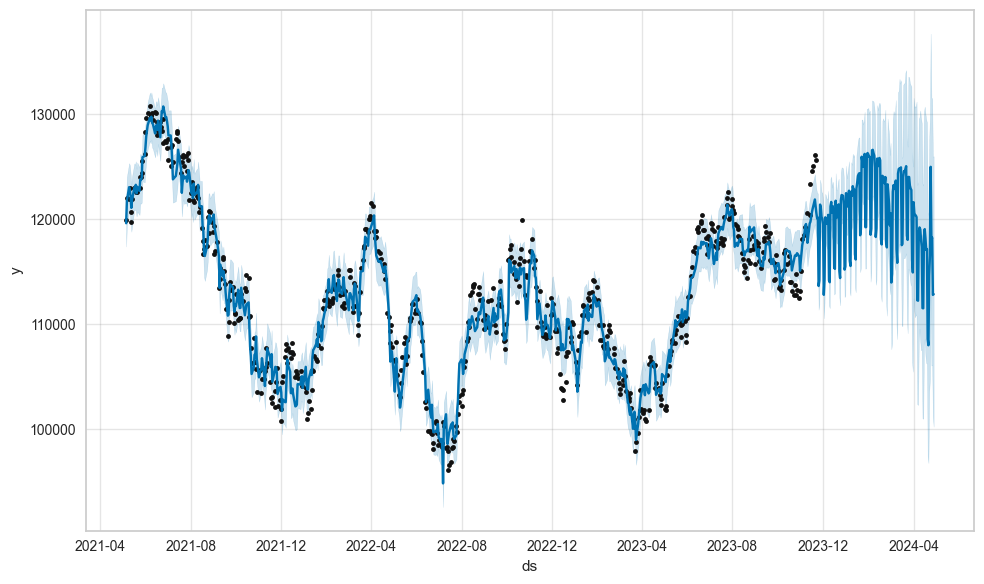

In [269]:
# Visualização das previsões
fig = model.plot(forecast)
fig.show()

In [273]:
# Avaliando o modelo
y_true = test_df['y'].values
y_pred = forecast['yhat'].values[-len(test_df):]

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 6754.452435270955
R2: -5.818482029823865
MAPE: 0.05275984412033657
RMSE: 8093.364552822251


#### Modelagem com um unico regressos (VIX)

In [274]:
# Cria e ajusta o modelo Prophet
model = Prophet()
model.add_regressor('vix')
model.fit(train_df)

00:08:00 - cmdstanpy - INFO - Chain [1] start processing
00:08:00 - cmdstanpy - INFO - Chain [1] done processing


In [275]:
# Faz as previsões
future = model.make_future_dataframe(periods=len(test_df))
future['vix'] = df_close['vix']

forecast = model.predict(future)

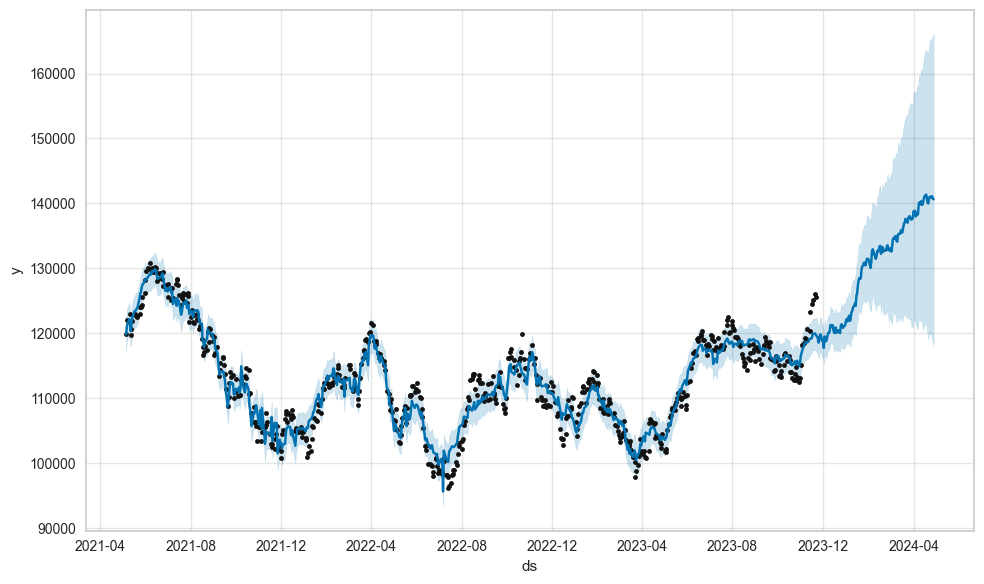

In [277]:
# Visualizando as previsões
fig = model.plot(forecast)
fig.show()

In [278]:
# Avaliando o modelo
y_true = test_df['y'].values
y_pred = forecast['yhat'].values[-len(test_df):]

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 8806.052610937673
R2: -9.803191397882792
MAPE: 0.06987673305952383
RMSE: 10187.351427786689


#### Modelagem sem regressores (somente a série VIX)

In [302]:
#Feature Scaling, normalização os dados
scaler = MinMaxScaler()
df_close_scaler = df_close
df_close_scaler[['Dollar', 'Volume', 'selic', 'vix', 'y']] = scaler.fit_transform(df_close_scaler[['Dollar', 'Volume', 'selic', 'vix', 'y']])

In [303]:
print(df_close_scaler)

            ds         y    Volume       vix     selic    Dollar
0   2021-05-06  0.625115  0.337297  0.554892  0.000000  0.659799
1   2021-05-07  0.680719  0.340582  0.477262  0.000000  0.590881
2   2021-05-10  0.677330  0.315763  0.469913  0.000000  0.557903
3   2021-05-11  0.705040  0.306908  0.521360  0.000000  0.546340
4   2021-05-12  0.619573  0.361331  0.611851  0.000000  0.545470
..         ...       ...       ...       ...       ...       ...
790 2024-07-05  0.791795  0.310635  0.013780  0.682927  0.406190
791 2024-07-08  0.799175  0.285459  0.023427  0.682927  0.762902
792 2024-07-09  0.813884  0.256811  0.005512  0.682927  0.762128
793 2024-07-10  0.816773  0.313209  0.000000  0.682927  0.715789
794 2024-07-11  0.845035  0.306305  0.006431  0.682927  0.713702

[795 rows x 6 columns]


In [304]:
# Divide os dados em treino (80%) e teste (20%)
train_df, test_df = train_test_split(df_close_scaler, test_size=0.2, shuffle=False)

In [315]:
# Cria e ajusta o modelo Prophet
model = Prophet()
model.fit(train_df)

00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing


In [316]:
# Faz as previsões
future = model.make_future_dataframe(periods=len(test_df))

forecast = model.predict(future)

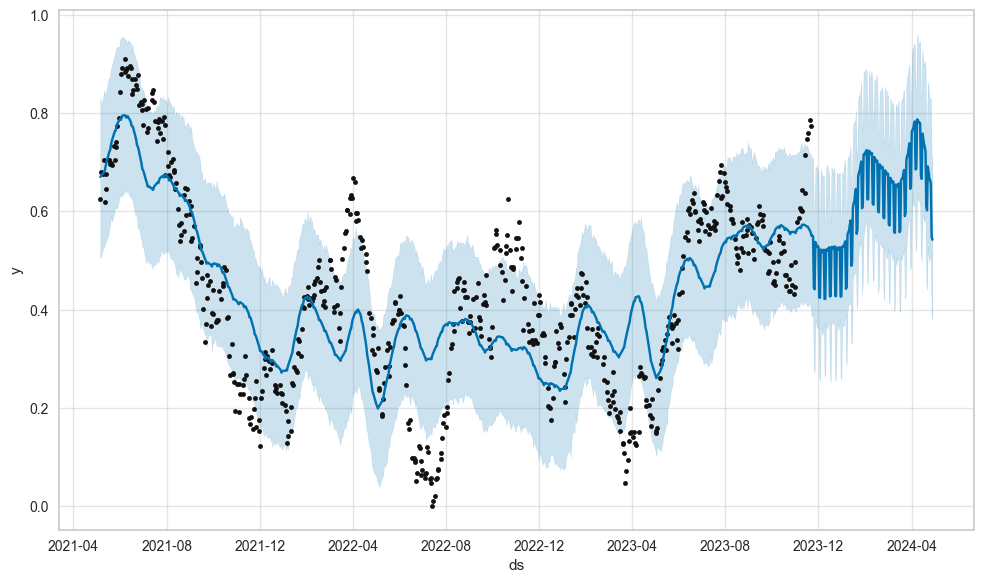

In [318]:
# Visualizando as previsões
fig = model.plot(forecast)
fig.show()

In [319]:

# Avaliando o modelo

y_true = test_df['y'].values
y_pred = forecast['yhat'].values[-len(test_df):]

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 0.2199067315437225
R2: -8.782710358605947
MAPE: 0.2612328748805969
RMSE: 0.25462307089190894
